In [ ]:
!pip install --upgrade transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import torch

In [ ]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzo del dispositivo: {device}")

Utilizzo del dispositivo: cuda


In [ ]:
# --- 1. LOAD DATA ---
try:
    train_df = pd.read_csv("train_set.csv")
    val_df = pd.read_csv("validation_set.csv")
    test_df = pd.read_csv("test_set.csv")
except FileNotFoundError:
    print("ERRORE: File di set non trovati.")
    print("Esegui prima 'split_data.py'.")
    exit()

# We Convert Dataframe into  'Dataset' of Hugging Face
ds = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test': Dataset.from_pandas(test_df)
})

print(f"Dataset caricati:\n{ds}")

Dataset caricati:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1800
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 385
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 385
    })
})


In [ ]:
# --- 2. LOAD TOKENIZER AND MODEL ---
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


# num_labels=2 (class 0 and class 1)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# --- 3. TOKENIZING THE DATA ---
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

# Tokenize in parallel
tokenized_datasets = ds.map(tokenize_function, batched=True)

# Remove the column 'text' and format for the training
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")



Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

In [ ]:
# --- 4. DEFINE EVALUATION METRICS ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# --- 5. DEFINE THE ARGUMENTS OF THE TRAINING---
training_args = TrainingArguments(
    output_dir="./polyphenol_classifier",
    eval_strategy="epoch",  # eval after each epoch
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

In [ ]:
# --- 6. CRETE THE TRAINER ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/tmp/ipython-input-3629444784.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# --- 7. TRAINING (FINE-TUNING) ---
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.002200,0.001684,1.000000,1.000000,1.000000,1.000000
2,0.000400,0.000382,1.000000,1.000000,1.000000,1.000000
3,0.000200,0.000107,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=675, training_loss=0.09036193452844465, metrics={'train_runtime': 579.5774, 'train_samples_per_second': 9.317, 'train_steps_per_second': 1.165, 'total_flos': 1420799698944000.0, 'train_loss': 0.09036193452844465, 'epoch': 3.0})

In [ ]:
# --- 8. FINAL EVAL ON TEST SET ---
print("\n--- VALUTAZIONE SUL TEST SET (DATI MAI VISTI) ---")
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])

print(f"Accuracy on Test Set: {test_results['eval_accuracy']:.4f}")
print(f"F1-score on Test Set: {test_results['eval_f1']:.4f}")
print(f"Precision on Test Set: {test_results['eval_precision']:.4f}")
print(f"Recall on Test Set: {test_results['eval_recall']:.4f}")


--- VALUTAZIONE SUL TEST SET (DATI MAI VISTI) ---


Accuracy on Test Set: 0.9974
F1-score on Test Set: 0.9981
Precision on Test Set: 0.9963
Recall on Test Set: 1.0000


In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])

logits = predictions.predictions
labels = predictions.label_ids


probs = torch.softmax(torch.tensor(logits), dim=1)

relevance_scores = probs[:, 1].numpy()


for i in range(5):
    print(f"Esempio {i+1}:")
    print(f"  RAW LOGITS : {logits[i]}")
    print(f"  Relevance score: {relevance_scores[i]:.4f}")
    print(f"  Label: {labels[i]}")


--- OTTENIMENTO DEI LOGITS E DELLE PROBABILITÀ ---


Esempio 1:
  Logits grezzi: [-3.1982083  3.6289856]
  Probabilità rilevante: 0.9989
  Etichetta vera: 1
Esempio 2:
  Logits grezzi: [-3.2154956  3.6247113]
  Probabilità rilevante: 0.9989
  Etichetta vera: 1
Esempio 3:
  Logits grezzi: [-3.2347488  3.6818738]
  Probabilità rilevante: 0.9990
  Etichetta vera: 1
Esempio 4:
  Logits grezzi: [-3.1275682  3.7170408]
  Probabilità rilevante: 0.9989
  Etichetta vera: 1
Esempio 5:
  Logits grezzi: [-3.2617943  3.7198803]
  Probabilità rilevante: 0.9991
  Etichetta vera: 1



Area Under the Curve (AUC): 0.9996


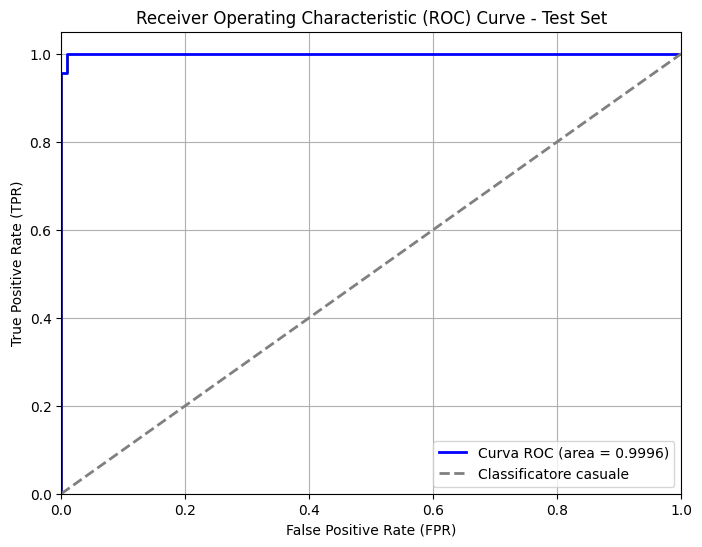

In [ ]:
# --- 9. AUC AND ROC  ---

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels, relevance_scores)


roc_auc = auc(fpr, tpr)
print(f"\nArea Under the Curve (AUC): {roc_auc:.4f}")

#  grafic
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Classificatore casuale')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score, ndcg_score
import numpy as np

# --- 9. RANKING-BASED ---

map_score = average_precision_score(labels, relevance_scores)

def mean_reciprocal_rank(y_true, y_score):
    sorted_indices = np.argsort(-y_score)
    for rank, idx in enumerate(sorted_indices, start=1):
        if y_true[idx] == 1:
            return 1.0 / rank
    return 0.0

mrr_score = mean_reciprocal_rank(labels, relevance_scores)
ndcg = ndcg_score([labels], [relevance_scores])

# Crea un dizionario con i risultati del ranking
ranking_results = {
    "eval_map": map_score,
    "eval_mrr": mrr_score,
    "eval_ndcg": ndcg
}

print(f"MAP: {map_score:.4f}")
print(f"MRR: {mrr_score:.4f}")
print(f"nDCG: {ndcg:.4f}")


--- Calcolo Metriche Ranking-Based ---
MAP: 0.9998
MRR: 1.0000
nDCG: 1.0000


In [ ]:
!zip -r modello_finito.zip ./polyphenol_classifier_final

  adding: polyphenol_classifier_final/ (stored 0%)
  adding: polyphenol_classifier_final/tokenizer.json (deflated 71%)
  adding: polyphenol_classifier_final/config.json (deflated 49%)
  adding: polyphenol_classifier_final/vocab.txt (deflated 54%)
  adding: polyphenol_classifier_final/model.safetensors (deflated 7%)
  adding: polyphenol_classifier_final/tokenizer_config.json (deflated 74%)
  adding: polyphenol_classifier_final/special_tokens_map.json (deflated 42%)
  adding: polyphenol_classifier_final/training_args.bin (deflated 53%)


In [ ]:

#save_results
with open("test_results.txt", "w") as f:
    f.write(str(test_results))

# Salva il modello finale
trainer.save_model("./polyphenol_classifier_final")

Modello finale salvato in './polyphenol_classifier_final'
